In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,random,matplotlib
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime as dt
import tensorflow as tf
from tensorflow import keras
import scipy.interpolate as interpolate
import scipy.signal as signal
from scipy.stats import linregress
sys.path.append('/home/giacomo/Documents/Denoiser_GPS/Denoiser_code')
sys.path.append('/home/giacomo/Documents/Denoiser_GPS/Common_mode_analysis/CMC_Code')
from funcs_4_DL_resids import *
from CMC_functions import denoise
import matplotlib.patches as patches
import matplotlib.pylab as pl
%matplotlib nbagg
sys.path.append('/home/giacomo/Documents/Denoiser_GPS/Denoiser_code')
from funcs_4_DL_resids import *


def filter(t,d,r,position,modelStep,model,scaler_cd,max_gap=5):

    """
    Apply the DL model to a time series
    
    Parameters
    ----------
       t: vectorized time vector
       data: folder of txt files
       input_length: length of the window to be considered as input (integer)
       target_size: size of the target
       position: position of the target within the input window
       model: Denoise model to use
       max_gap: maximum gap for having nans in the series (int)
       
    Returns
    ----------
       filtered: fileterd time series
       time_filtered: time vector of the filtered time series

    """
    
    ### load mean and std
    mean=float(np.load(scaler_cd+'/Mean_std.npz')['mean'])
    std=float(np.load(scaler_cd+'/Mean_std.npz')['std'])
    
    ## load models
    try:
        modelStep = keras.models.load_model(modelStep)
        model = keras.models.load_model(model)
    except:
        modelStep = tf.saved_model.load(modelStep)
        model =tf.saved_model.load(model)
    
    input_length=modelStep.layers[-1].output_shape[1]
    print(input_length)
    
    target_size=model.layers[-1].output_shape[1]
    print(target_size)

    ## interpolating only if there are missing gaps (nans values inside)
    if np.isnan(d).any() or len(np.argwhere(np.diff(t)>1)):
        t,d,r,h = elongate_and_interpolate(t,d,r,r,max_gap)
    else:
        t,d,r,h=t,d,r,r
    
    #### Making X and y
    X,Y,H_vector,H_Vel = XY_from_d_and_length(d,r,h,input_length)

    #### no nan indexes
    indexes=[ind[0] for ind in np.argwhere(~np.isnan(X).any(axis=1))]
                    
    X=X[indexes,:]
    #Y=Y[indexes,:]
    
    #Apply the scaling
    for jj in range(X.shape[0]):
        X[jj,:]=(X[jj,:]-mean)/std
                
    predictions_step=modelStep.predict(X)
    predictions_step=tf.squeeze(predictions_step)

    New_X=tf.transpose(tf.stack([predictions_step,X]),[1,2,0])
    predictions=model.predict(New_X)
    predictions=predictions.squeeze()
    
    t=t[indexes]+position
    d=d[position:][indexes]
    r=r[position:][indexes]
            
    return t,d,r,predictions,predictions_step,input_length

2023-08-10 01:24:08.292106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 01:24:08.420537: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 01:24:08.436894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-10 01:24:08.436903: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Num GPUs Available:  0


2023-08-10 01:24:09.608172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-10 01:24:09.608192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: giacomo-Z590-AORUS-MASTER
2023-08-10 01:24:09.608202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: giacomo-Z590-AORUS-MASTER
2023-08-10 01:24:09.608374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-08-10 01:24:09.608386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.125.6
2023-08-10 01:24:09.608388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.125.6


In [90]:
comp='E'
station='PALE'
cd_data='/home/giacomo/Documents/Denoiser_GPS/Wordwide_dataset/t_disps_resids/'

cd_base='/home/giacomo/Documents/Denoiser_GPS/Common_mode_analysis/'
#import list of all stations
df = pd.read_csv('/home/giacomo/Documents/Denoiser_GPS/Wordwide_dataset/Stations_coordinates.txt', delimiter=',',names=['station','latitude','longitude','altitude'],header=None)
thr_distance=500 #in km
save_flag=False



In [92]:
comp='E'
cd_data='/home/giacomo/Documents/Synthetic_datasetNEW/t_disps_residsF_E_N/'
fileCounter = len(glob.glob1(cd_data+'E/',"*.txt"))



### Plot varying the Input length

<IPython.core.display.Javascript object>


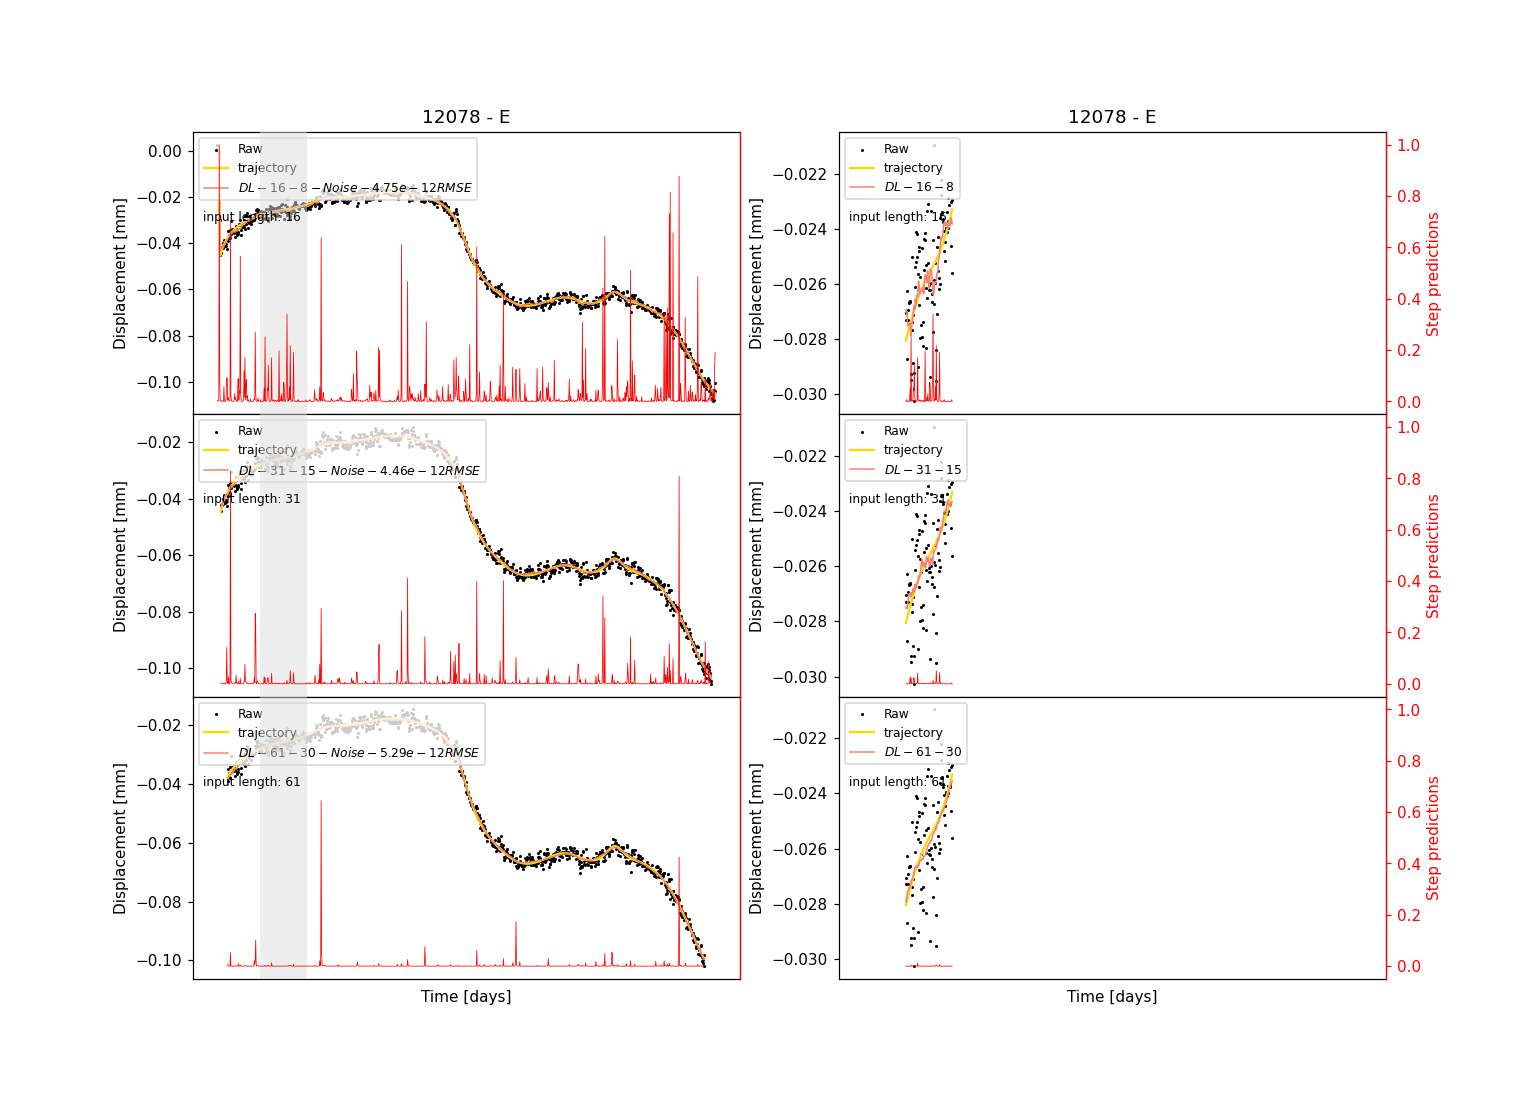

The input_length is:  16  The position is:  15
16
1
34/34 [==============================] - 1s 8ms/step
The input_length is:  31  The position is:  30
31
1
33/33 [==============================] - 2s 14ms/step
The input_length is:  61  The position is:  60
61
1
32/32 [==============================] - 2s 26ms/step


In [108]:
#################### DL ####################
station= random.sample(range(fileCounter), 1)[0]
station=str(station)
station=str(12078)
#sample=8300
in_path = cd_data+str(station)+'.txt'

input_lengths=[16,31,61]
predictionsT=[]
models_gr='Gratsid_modelN_noskip_'

fig,axes=plt.subplots(len(input_lengths),2,figsize=(14,10),sharex=True)
plt.subplots_adjust(wspace=0.18,hspace=0)
axes[0,0].set_title(station+' - '+comp)
axes[0,1].set_title(station+' - '+comp)

for i in range(len(input_lengths)):
    t=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,0]
    d=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,1]
    r=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,2]
    
    #t_cmc,r_cmc,d_cmc,median_res=denoise(comp,t,d,r,df,station,thr_distance,cd_base,cd_data)
    #t=t-t[0]
    #t_cmc=t_cmc-t_cmc[0]
    
    ### interpolate
    t_old=t
    t = np.linspace(t_old[0], t_old[-1], int(t_old[-1]-t_old[0]))
    g_interp = np.interp(t, t_old, d-r)
    d = np.interp(t, t_old, d)
    r=d-g_interp
    
    input_length=input_lengths[i]
    
    ######################## position ########################
    position=int(input_length-1)
    print('The input_length is: ',input_length,' The position is: ',position)
    
    #scaler_cd='/home/giacomo/Documents/old/Synthetic_dataset_'+str(input_length)
    scaler_cd='/home/giacomo/Documents/S_NEW_E_N_'+str(input_length)  #old/Synthetic_dataset_
    modelStep=scaler_cd+'/Step_model_skip'

    position=int(input_lengths[i]/2)
    model=scaler_cd+'/models/'+models_gr+str(position)
    tt,dd,rr,predictions,predictions_step,input_length=filter(t,d,r,position,modelStep,model,scaler_cd,max_gap=5)
    trend=linregress(tt,dd)
    trend_vector=tt*trend.slope+trend.intercept
    trend_DL=linregress(tt,(dd-predictions))
    trend_vector_DL=t*trend_DL.slope+trend_DL.intercept
        
        
    axes[i,0].scatter(tt,(dd),s=1,label='Raw',color='k')
    ax=axes[i,0].twinx()
    p3,=ax.plot(tt,predictions_step[:,position],color='r',linewidth=0.5,label='input length: '+str(input_length))
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    plt.setp(ax.spines.values(), visible=False)
    ax.spines["right"].set_visible(True)
    ax.yaxis.label.set_color(p3.get_color())
    ax.spines["right"].set_edgecolor(p3.get_color())
    ax.tick_params(axis='y', colors=p3.get_color())
    ax.set_yticks([]) 
    if i!=2:
        ax.set_xticks([]) 
    ax.set_ylabel('',fontsize='10',color=p3.get_color())
    axes[i,0].set_ylabel('Displacement [mm]',fontsize=10) 
    axes[i,0].set_xlabel('Time [days]') 
    axes[i,0].plot(tt,(dd-rr),label='trajectory',color='gold',linewidth=1.5)
    axes[i,0].plot(tt,(dd-predictions),color='salmon',label='$DL - '+str(input_lengths[i])+' - '+str(position)+' -Noise - '+str(round(np.square(np.mean(predictions**2)),14))+'RMSE$',linewidth=1)
    axes[i,0].legend(loc='upper left',fontsize=8)
    ax.set_ylim([-0.05,1.05])
    
    
    #################### Zoom Time index ####################
    #init=735558 ### MAHI
    #nit=735820 #UNRO 
    ### J083 734155 
    #init=736530 ### Pale
    #init=735700 #J546
    #init=735570 #CN40 
    init=100
    ttt=np.arange(tt[tt==init],tt[tt==init+100])
    rect = patches.Rectangle((ttt[0], -0.1), 100, 1.2, linewidth=0, edgecolor='k', facecolor='gainsboro',alpha=0.5)
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    tt_ind=np.arange(np.argwhere(tt==init),np.argwhere(tt==init+100))
    ddd=dd[tt_ind]
    rrr=rr[tt_ind]
    predictions_stepN=np.array(predictions_step)[tt_ind,position]
    predictions_zoom=np.array(predictions)[tt_ind]
    
    axes[i,1].scatter(ttt,(ddd),s=1,label='Raw',color='k')
    axes[i,1].plot(ttt,(ddd-rrr),label='trajectory',color='gold',linewidth=1.5)
    axes[i,1].plot(ttt,(ddd-predictions_zoom),color='salmon',label='$DL - '+str(input_lengths[i])+' - '+str(position)+'$',linewidth=1)

    #axes[i,1].tick_params(axis='y', which='major', labelsize=7)
    ax2=axes[i,1].twinx()
    p32,=ax2.plot(ttt,predictions_stepN,color='r',linewidth=0.5,label='input length: '+str(input_length))
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    plt.setp(ax2.spines.values(), visible=False)
    ax2.spines["right"].set_visible(True)
    ax2.yaxis.label.set_color(p32.get_color())
    ax2.spines["right"].set_edgecolor(p32.get_color())
    ax2.tick_params(axis='y', colors=p32.get_color())
    ax2.set_ylabel('Step predictions',fontsize='10',color=p32.get_color())
    #ax2.set_xlim([t[0],t[-1]])
    axes[i,1].set_ylabel('Displacement [mm]',fontsize=10) 
    axes[i,1].set_xlabel('Time [days]') 
    axes[i,1].legend(loc='upper left',fontsize=8)
    ax2.set_ylim([-0.05,1.05])
    props = dict(boxstyle='round', facecolor='w', alpha=0)
    # place a text box in upper left in axes coords
    ax2.text(0.02, 0.72, 'input length: '+str(input_length), transform=ax2.transAxes, fontsize=8,
                 verticalalignment='top', bbox=props)
    ax.text(0.02, 0.72, 'input length: '+str(input_length), transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
    
#for i in range(len(input_lengths)):    
    #axes[i,0].set_xlim([tt[0],tt[-1]])       
    #axes[i,1].set_xlim([ttt[0],ttt[-1]])     

        
        
#plt.savefig('/home/giacomo/Documents/Noise_predictions_input_length_'+str(station)+'.pdf')

In [95]:
tt

array([  31,   32,   33, ..., 1049, 1050, 1051])

In [63]:
tt[tt==735584]

array([735584])

In [59]:
tt==

array([735384, 735385, 735386, ..., 736827, 736828, 736829])

### Plot varying the position

<IPython.core.display.Javascript object>


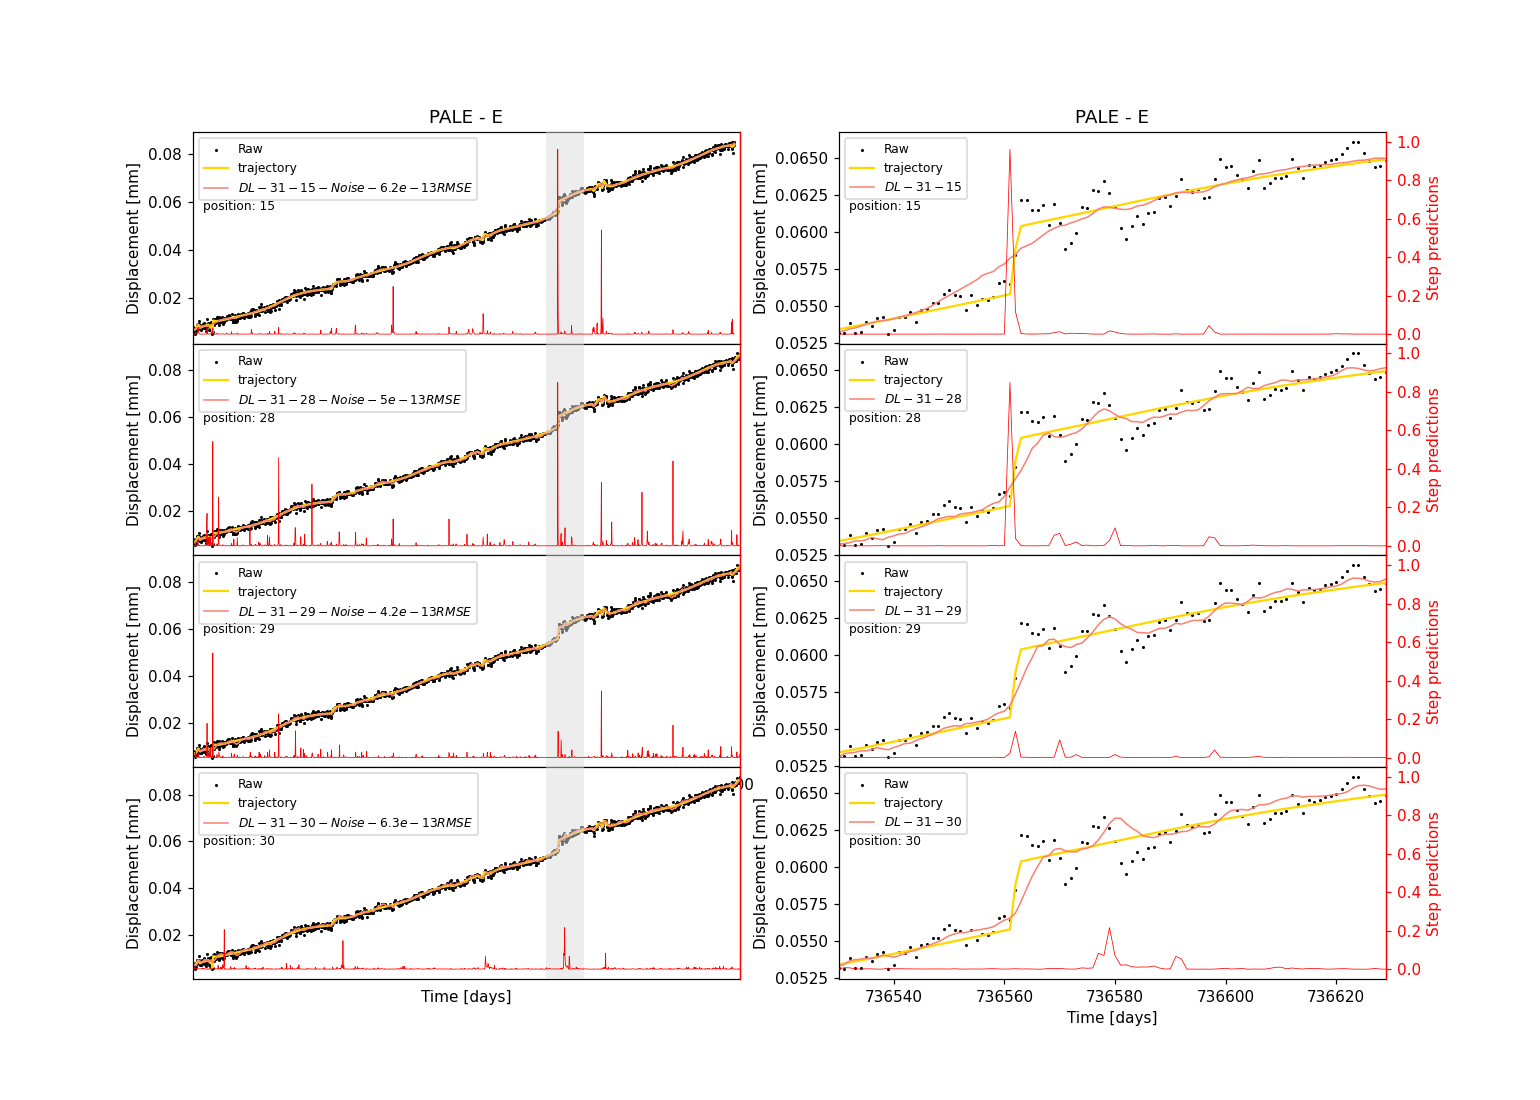

The input_length is:  31  The position is:  15
31
1
45/45 [==============================] - 2s 14ms/step
The input_length is:  31  The position is:  28
31
1
45/45 [==============================] - 2s 14ms/step
The input_length is:  31  The position is:  29
31
1
45/45 [==============================] - 2s 14ms/step
The input_length is:  31  The position is:  30
31
1
45/45 [==============================] - 2s 13ms/step


In [70]:
#### Choose input_length ####
input_length=31
n_positions=[input_length/2,input_length-3,input_length-2,input_length-1] #number of tested positions
n_positions=[int(np) for np in n_positions]

fig,axes=plt.subplots(len(n_positions),2,figsize=(14,10))
plt.subplots_adjust(wspace=0.18,hspace=0)
axes[0,0].set_title(station+' - '+comp)
axes[0,1].set_title(station+' - '+comp)

for i in range(len(n_positions)):
    t=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,0]
    d=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,1]
    r=np.loadtxt(cd_data+comp+'/'+station+'.txt')[:,2]
    
    t_cmc,r_cmc,d_cmc,median_res=denoise(comp,t,d,r,df,station,thr_distance,cd_base,cd_data)
    #t=t-t[0]
    #t_cmc=t_cmc-t_cmc[0]
    
    ### interpolate
    t_old=t
    t = np.linspace(t_old[0], t_old[-1], int(t_old[-1]-t_old[0]))
    g_interp = np.interp(t, t_old, d-r)
    d = np.interp(t, t_old, d)
    r=d-g_interp
    
    
    ######################## position ########################
    position=n_positions[i]
    print('The input_length is: ',input_length,' The position is: ',position)
    
    
    scaler_cd='/home/giacomo/Documents/S_NEW_E_N_'+str(input_length)  #old/Synthetic_dataset_
    #scaler_cd='/home/giacomo/Documents/old/Synthetic_dataset_'+str(input_length)
    modelStep=scaler_cd+'/Step_model_skip'
    model=scaler_cd+'/models/'+models_gr+str(position)
    tt,dd,rr,predictions,predictions_step,input_length=filter(t,d,r,position,modelStep,model,scaler_cd,max_gap=5)
    trend=linregress(tt,dd)
    trend_vector=tt*trend.slope+trend.intercept
    trend_DL=linregress(tt,(dd-predictions))
    trend_vector_DL=t*trend_DL.slope+trend_DL.intercept
        
        
    axes[i,0].scatter(tt,(dd),s=1,label='Raw',color='k')
    ax=axes[i,0].twinx()
    p3,=ax.plot(tt,predictions_step[:,position],color='r',linewidth=0.5,label='input length: '+str(input_length))
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    plt.setp(ax.spines.values(), visible=False)
    ax.spines["right"].set_visible(True)
    ax.yaxis.label.set_color(p3.get_color())
    ax.spines["right"].set_edgecolor(p3.get_color())
    ax.tick_params(axis='y', colors=p3.get_color())
    ax.set_yticks([]) 
    if i!=2:
        ax.set_xticks([]) 
    ax.set_ylabel('',fontsize='10',color=p3.get_color())
    axes[i,0].set_ylabel('Displacement [mm]',fontsize=10) 
    axes[i,0].set_xlabel('Time [days]') 
    axes[i,0].plot(tt,(dd-rr),label='trajectory',color='gold',linewidth=1.5)
    axes[i,0].plot(tt,(dd-predictions),color='salmon',label='$DL - '+str(input_length)+' - '+str(position)+' -Noise - '+str(round(np.square(np.mean(predictions**2)),14))+'RMSE$',linewidth=1)
    axes[i,0].legend(loc='upper left',fontsize=8)
    ax.set_ylim([-0.05,1.05])

    #################### Zoom Time index ####################
    #init=736530 ### Pale
    #init=735558 ### MAHI
    #init=734155 ### J083
    ttt=np.arange(tt[tt==init],tt[tt==init+100])
    rect = patches.Rectangle((ttt[0], -0.1), 100, 1.2, linewidth=0, edgecolor='k', facecolor='gainsboro',alpha=0.5)
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    tt_ind=np.arange(np.argwhere(tt==init),np.argwhere(tt==init+100))
    ddd=dd[tt_ind]
    rrr=rr[tt_ind]
    predictions_stepN=np.array(predictions_step)[tt_ind,position]
    predictions_zoom=np.array(predictions)[tt_ind]
    
    axes[i,1].scatter(ttt,(ddd),s=1,label='Raw',color='k')
    axes[i,1].plot(ttt,(ddd-rrr),label='trajectory',color='gold',linewidth=1.5)
    axes[i,1].plot(ttt,(ddd-predictions_zoom),color='salmon',label='$DL - '+str(input_length)+' - '+str(position)+'$',linewidth=1)

    #axes[i,1].tick_params(axis='y', which='major', labelsize=7)
    ax2=axes[i,1].twinx()
    p32,=ax2.plot(ttt,predictions_stepN,color='r',linewidth=0.5,label='input length: '+str(input_length))
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    plt.setp(ax2.spines.values(), visible=False)
    ax2.spines["right"].set_visible(True)
    ax2.yaxis.label.set_color(p32.get_color())
    ax2.spines["right"].set_edgecolor(p32.get_color())
    ax2.tick_params(axis='y', colors=p32.get_color())
    ax2.set_ylabel('Step predictions',fontsize='10',color=p32.get_color())
    ax2.set_xlim([tt[0],tt[-1]])
    axes[i,1].set_ylabel('Displacement [mm]',fontsize=10) 
    axes[i,1].set_xlabel('Time [days]') 
    axes[i,1].legend(loc='upper left',fontsize=8)
    ax2.set_ylim([-0.05,1.05])
    props = dict(boxstyle='round', facecolor='w', alpha=0)
    # place a text box in upper left in axes coords
    ax2.text(0.02, 0.68, 'position: '+str(position), transform=ax2.transAxes, fontsize=8,
                 verticalalignment='top', bbox=props)
    ax.text(0.02, 0.68, 'position: '+str(position), transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)

for i in range(len(n_positions)):    
    axes[i,0].set_xlim([tt[0],tt[-1]])       
    axes[i,1].set_xlim([ttt[0],ttt[-1]])     

        
        
#plt.savefig('/home/giacomo/Documents/Noise_predictions_positions_'+str(station)+'.pdf')

## Plot std-window length-position rmse 

The input_length is:  31  The position is:  30


<IPython.core.display.Javascript object>


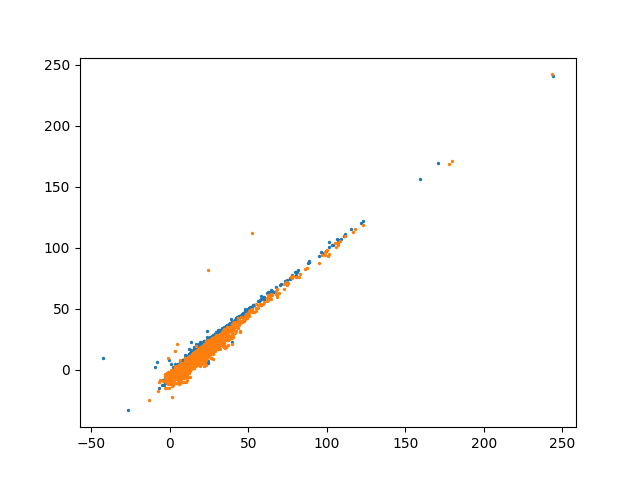

In [65]:
#################### DL ####################
input_length=31
position=30
#position=int(input_length/2)
print('The input_length is: ',input_length,' The position is: ',position)
scaler_cd='/home/giacomo/Documents/S_NEW_'+str(input_length)
cd_eval='/Evaluation_files_'+str(position)

STD_ts=np.load(scaler_cd+cd_eval+'/STD_ts_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
STD_resid=np.load(scaler_cd+cd_eval+'/STD_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
RMSE_resid=np.load(scaler_cd+cd_eval+'/RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
Relative_RMSE_resid=np.load(scaler_cd+cd_eval+'/Relative_RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
diff_PSD=np.load(scaler_cd+cd_eval+'/diff_PSD_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
diff_PSD_Noise=np.load(scaler_cd+cd_eval+'/diff_PSD_Noise_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
CC_SR_DL=np.load(scaler_cd+cd_eval+'/CC_SR_DL'+str(input_length)+'_pos_'+str(position)+'.npy') 
CC_SR_cmc=np.load(scaler_cd+cd_eval+'/CC_SR_cmc'+str(input_length)+'_pos_'+str(position)+'.npy') 

plt.figure()
plt.scatter(CC_SR_DL[:,0],CC_SR_DL[:,1],s=2,label='DL')
plt.scatter(CC_SR_cmc[:,0],CC_SR_cmc[:,1],s=2,label='CMF ')
#plt.xlim(0,0.008)
#plt.ylim(0,0.008)

In [39]:
diff_PSD[0,0].shape

(129,)

<IPython.core.display.Javascript object>


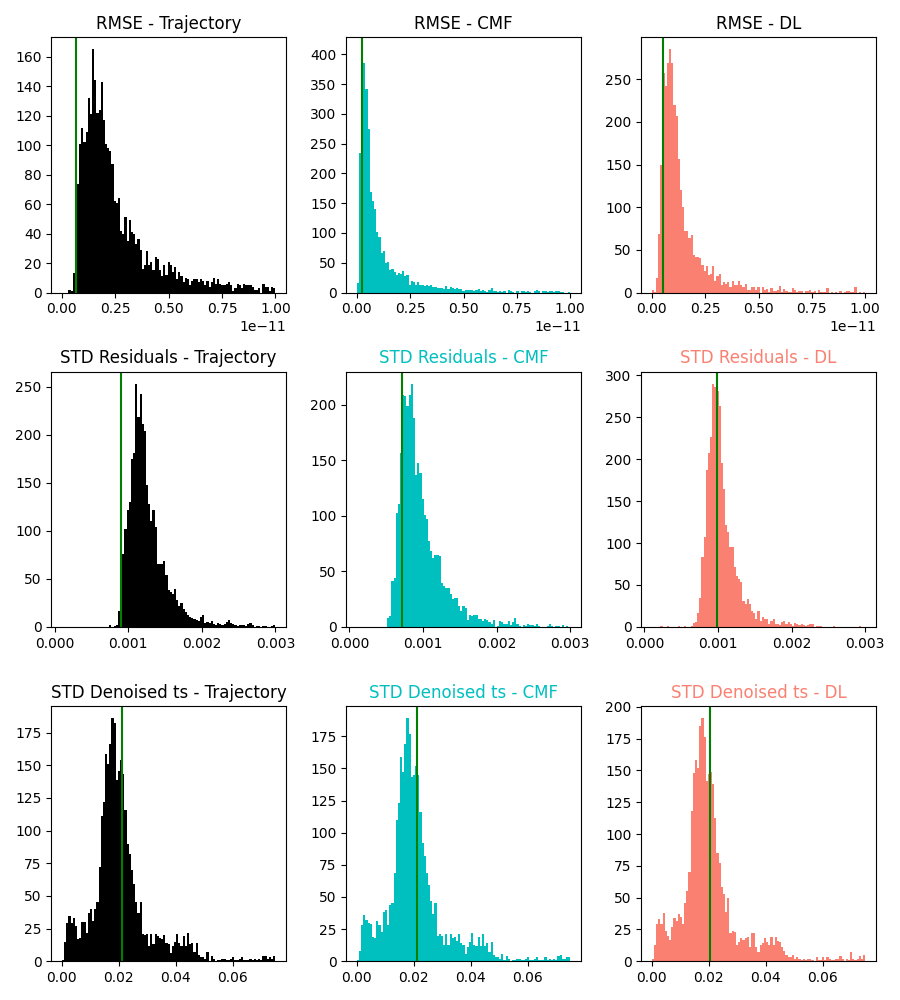

<IPython.core.display.Javascript object>


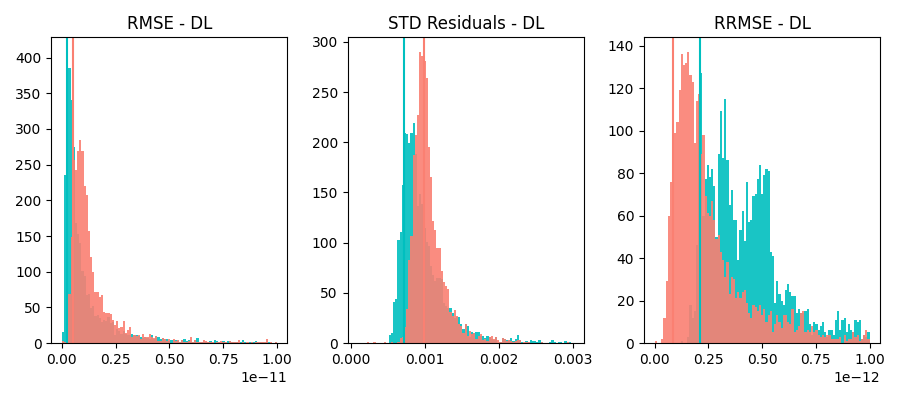

<IPython.core.display.Javascript object>


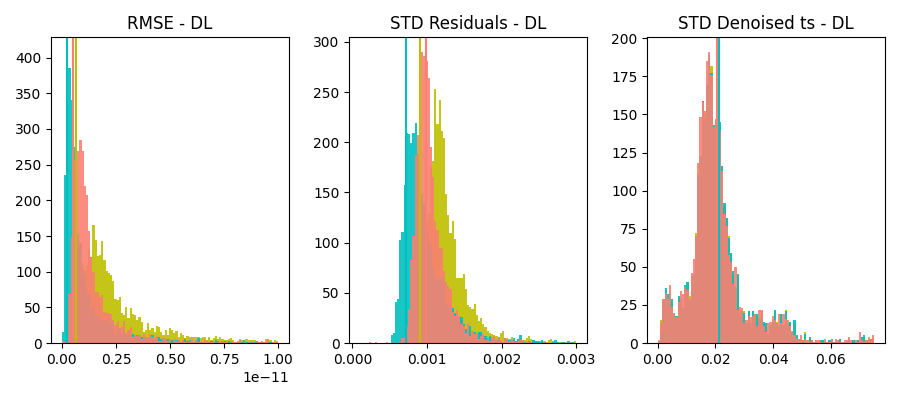

<IPython.core.display.Javascript object>


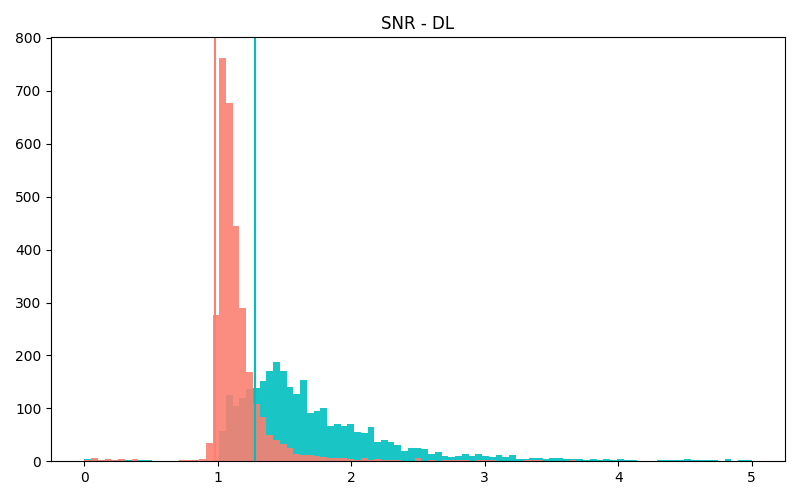

In [66]:
import statistics
%matplotlib nbagg
fig, axs = plt.subplots(3,3, sharey=False, tight_layout=True,figsize=(9,10))

methods=['Trajectory','CMF','DL']
colors=['k','c','salmon']
bin1=np.linspace(0,1e-11,100)
bin2=np.linspace(0.0001,0.003,100)
bin3=np.linspace(0.0001,0.075,100)
for i in range(3):
    axs[0,i].hist(RMSE_resid[:,i],bins=bin1, color=colors[i])
    axs[0,i].set_title('RMSE - '+methods[i],fontsize=12)
    axs[0,i].axvline(x=statistics.mode(RMSE_resid[:,i]),color='g')

    axs[1,i].hist(STD_resid[:,i], bins=bin2, color=colors[i])
    axs[1,i].set_title('STD Residuals - '+methods[i],fontsize=12,color=colors[i])
    axs[1,i].axvline(x=statistics.mode(STD_resid[:,i]),color='g')

    axs[2,i].hist(STD_ts[:,i], bins=bin3, color=colors[i])
    axs[2,i].set_title('STD Denoised ts - '+methods[i],fontsize=12,color=colors[i])
    axs[2,i].axvline(x=statistics.mode(STD_ts[:,i]),color='g')

plt.show()


fig, axs = plt.subplots(1,3, sharey=False, tight_layout=True,figsize=(9,4))

methods=['CMF','DL']
colors=['c','salmon']
bin1=np.linspace(0,1e-11,100)
bin2=np.linspace(0.0001,0.003,100)
bin3=np.linspace(0,1e-12,100)
binT=[bin1,bin2,bin3]
titles=['RMSE - ','STD Residuals - ','RRMSE - ']
metric=[RMSE_resid[:,1:],STD_resid[:,1:],Relative_RMSE_resid]

for z in range(3):
    for i in range(2):
        axs[z].hist(metric[z][:,i],bins=binT[z], color=colors[i],alpha=0.9)
        axs[z].set_title(titles[z]+methods[i],fontsize=12)
        axs[z].axvline(x=statistics.mode(metric[z][:,i]),color=colors[i])

plt.show()
plt.savefig('/home/giacomo/Documents/FIGURES_combined/histograms/RMSE_resid_STD'+str(input_length)+'_'+str(position)+'.pdf')


fig, axs = plt.subplots(1,3, sharey=False, tight_layout=True,figsize=(9,4))

methods=['Trajectory','CMF','DL']
colors=['y','c','salmon']
bin1=np.linspace(0,1e-11,100)
bin2=np.linspace(0.0001,0.003,100)
bin3=np.linspace(0.0001,0.075,100)
binT=[bin1,bin2,bin3]
titles=['RMSE - ','STD Residuals - ','STD Denoised ts - ']
metric=[RMSE_resid,STD_resid,STD_ts]

for z in range(3):
    for i in range(3):
        axs[z].hist(metric[z][:,i],bins=binT[z], color=colors[i],alpha=0.9)
        axs[z].set_title(titles[z]+methods[i],fontsize=12)
        axs[z].axvline(x=statistics.mode(metric[z][:,i]),color=colors[i])

plt.show()
plt.savefig('/home/giacomo/Documents/FIGURES_combined/histograms/RRMSE_'+str(input_length)+'_'+str(position)+'.pdf')


fig, axs = plt.subplots(1,1, sharey=False, tight_layout=True,figsize=(8,5))

methods=['CMF','DL']
colors=['c','salmon']
'''
bin1=np.linspace(0,1e-11,100)
bin2=np.linspace(0.0001,0.003,100)
bin3=np.linspace(0.0001,0.075,100)
binT=[bin1,bin2,bin3]
'''
titles=['SNR - ','SNR - ']
metric=[CC_SR_cmc,CC_SR_DL]

bin1=np.linspace(0,5,100)
for z in range(len(metric)):
    axs.hist(metric[z][:,0]/metric[z][:,1], bins=bin1,color=colors[z],alpha=0.9) #bins=binT[z]
    axs.set_title(titles[z]+methods[z],fontsize=12)
    axs.axvline(x=statistics.mode(metric[z][:,0]/metric[z][:,1]),color=colors[z])

plt.show()

In [57]:
 10*np.log(10/ 2)

16.094379124341003

In [58]:
 10*np.log(5/ 2)

9.16290731874155

<IPython.core.display.Javascript object>


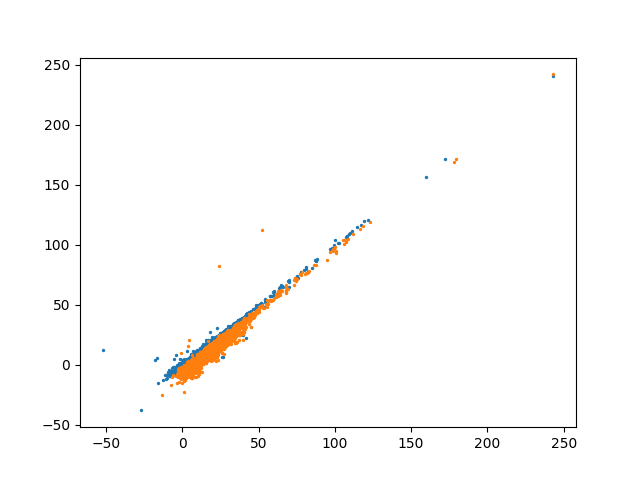

In [84]:
plt.figure()
plt.scatter(CC_SR_DL[:,0],CC_SR_DL[:,1],s=2,label='DL')
plt.scatter(CC_SR_cmc[:,0],CC_SR_cmc[:,1],s=2,label='CMF ')
#plt.xlim(0,0.008)
#plt.ylim(0,0.008)

In [85]:
diff_cmf=np.zeros(129)
z=0
for i in range(len(diff_PSD_Noise[:,0])):
    if diff_PSD_Noise[i,0].shape==diff_cmf.shape:
        z+=1
        diff_cmf=diff_cmf+diff_PSD_Noise[i,0]
Mean_psd=diff_cmf/z

import matplotlib.pylab as pl
aa=np.zeros(365*4)
(f, S)= scipy.signal.welch(aa, 1)
colors=pl.cm.spring(np.linspace(0,1,4))
fig,axes=plt.subplots(1,1,figsize=(6,6),sharex=True)
axes.loglog(f,Mean_psd)
axes.set_xlim([10**(-2),max(f)])
axes.set_xlabel('Frequency')  
axes.set_ylabel('PSD',fontsize=7) 
axes.tick_params(axis='both', which='major', labelsize=8)
axes.axvline(x=1/365,color=colors[0],linewidth=1,label='1 year')
axes.axvline(x=1/(365/2),color=colors[1],linewidth=1,label='0.5 year')
axes.axvline(x=1/61,color=colors[2],linewidth=1,label='60 days')
axes.axvline(x=1/30,color=colors[3],linewidth=1,label='30 days')
axes.axvline(x=1/14,color=colors[3],linewidth=1,label='14 days')
axes.axvline(x=1/7,color=colors[3],linewidth=1,label='7 days')
axes.axvline(x=1/5,color=colors[3],linewidth=1,label='5 days')
axes.legend(prop={'size': 7},loc='upper left',facecolor="white")
               

<IPython.core.display.Javascript object>


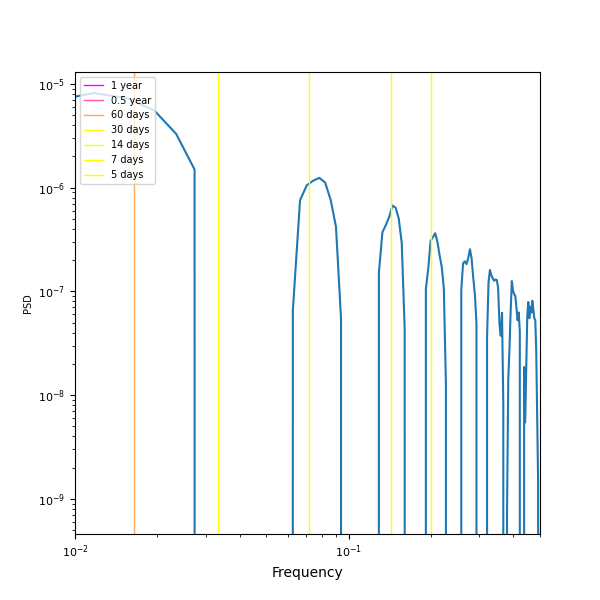

In [25]:
RMSE_resid[:,2]

(3338,)

In [26]:
#################### DL ####################
input_length=31
position=30
#position=int(input_length/2)
print('The input_length is: ',input_length,' The position is: ',position)
scaler_cd='/home/giacomo/Documents/S_NEW_'+str(input_length)
cd_eval='/Evaluation_files_'+str(position)

STD_ts=np.load(scaler_cd+cd_eval+'/STD_ts_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
STD_resid=np.load(scaler_cd+cd_eval+'/STD_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
RMSE_resid=np.load(scaler_cd+cd_eval+'/RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
Relative_RMSE_resid=np.load(scaler_cd+cd_eval+'/Relative_RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
diff_PSD=np.load(scaler_cd+cd_eval+'/diff_PSD_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
diff_PSD_Noise=np.load(scaler_cd+cd_eval+'/diff_PSD_Noise_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
CC_SR_DL=np.load(scaler_cd+cd_eval+'/CC_SR_DL'+str(input_length)+'_pos_'+str(position)+'.npy') 
CC_SR_cmc=np.load(scaler_cd+cd_eval+'/CC_SR_cmc'+str(input_length)+'_pos_'+str(position)+'.npy') 



The input_length is:  31  The position is:  30


In [61]:
i=0
k=0
input_lengths=[16,31,61]
positions=[1,2,3,4]
STD_residT=np.zeros([len(input_lengths),len(positions)])
STD_tsT=np.zeros([len(input_lengths),len(positions)])
RMSE_residT=np.zeros([len(input_lengths),len(positions)])
Relative_RMSE_residT=np.zeros([len(input_lengths),len(positions)])
cd_eval='/Evaluation_files_'+str(position)
for input_length in input_lengths:
    for k in range(len(positions)):
        if k<3:
            position=input_length-positions[k]
        else:
            position=int(input_length/2)
        print('The input_length is: ',input_length,' The position is: ',position)
        scaler_cd='/home/giacomo/Documents/S_NEW_'+str(input_length)
        cd_eval='/Evaluation_files_'+str(position)
        
        STD_ts=np.load(scaler_cd+cd_eval+'/STD_ts_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
        STD_resid=np.load(scaler_cd+cd_eval+'/STD_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
        RMSE_resid=np.load(scaler_cd+cd_eval+'/RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
        Relative_RMSE_resid=np.load(scaler_cd+cd_eval+'/Relative_RMSE_resid_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy') 
        diff_PSD=np.load(scaler_cd+cd_eval+'/diff_PSD_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
        diff_PSD_Noise=np.load(scaler_cd+cd_eval+'/diff_PSD_Noise_inpl_'+str(input_length)+'_pos_'+str(position)+'.npy',allow_pickle=True) 
        CC_SR_DL=np.load(scaler_cd+cd_eval+'/CC_SR_DL'+str(input_length)+'_pos_'+str(position)+'.npy') 
        CC_SR_cmc=np.load(scaler_cd+cd_eval+'/CC_SR_cmc'+str(input_length)+'_pos_'+str(position)+'.npy') 
        STD_residT[i,k]=np.mean(STD_resid[:,2])
        STD_tsT[i,k]=np.mean(STD_ts[:,2])
        RMSE_residT[i,k]=np.mean(RMSE_resid[:,2])
        Relative_RMSE_residT[i,k]=np.mean(Relative_RMSE_resid[:,1])

    i+=1

    

The input_length is:  16  The position is:  15
The input_length is:  16  The position is:  14
The input_length is:  16  The position is:  13
The input_length is:  16  The position is:  8
The input_length is:  31  The position is:  30
The input_length is:  31  The position is:  29
The input_length is:  31  The position is:  28
The input_length is:  31  The position is:  15
The input_length is:  61  The position is:  60
The input_length is:  61  The position is:  59
The input_length is:  61  The position is:  58
The input_length is:  61  The position is:  30


In [62]:
STD_residT

array([[0.00087321, 0.00084534, 0.00092781, 0.00105617],
       [0.00106084, 0.00096698, 0.00099803, 0.00104961],
       [0.00105642, 0.00100801, 0.00100468, 0.00110258]])

<IPython.core.display.Javascript object>


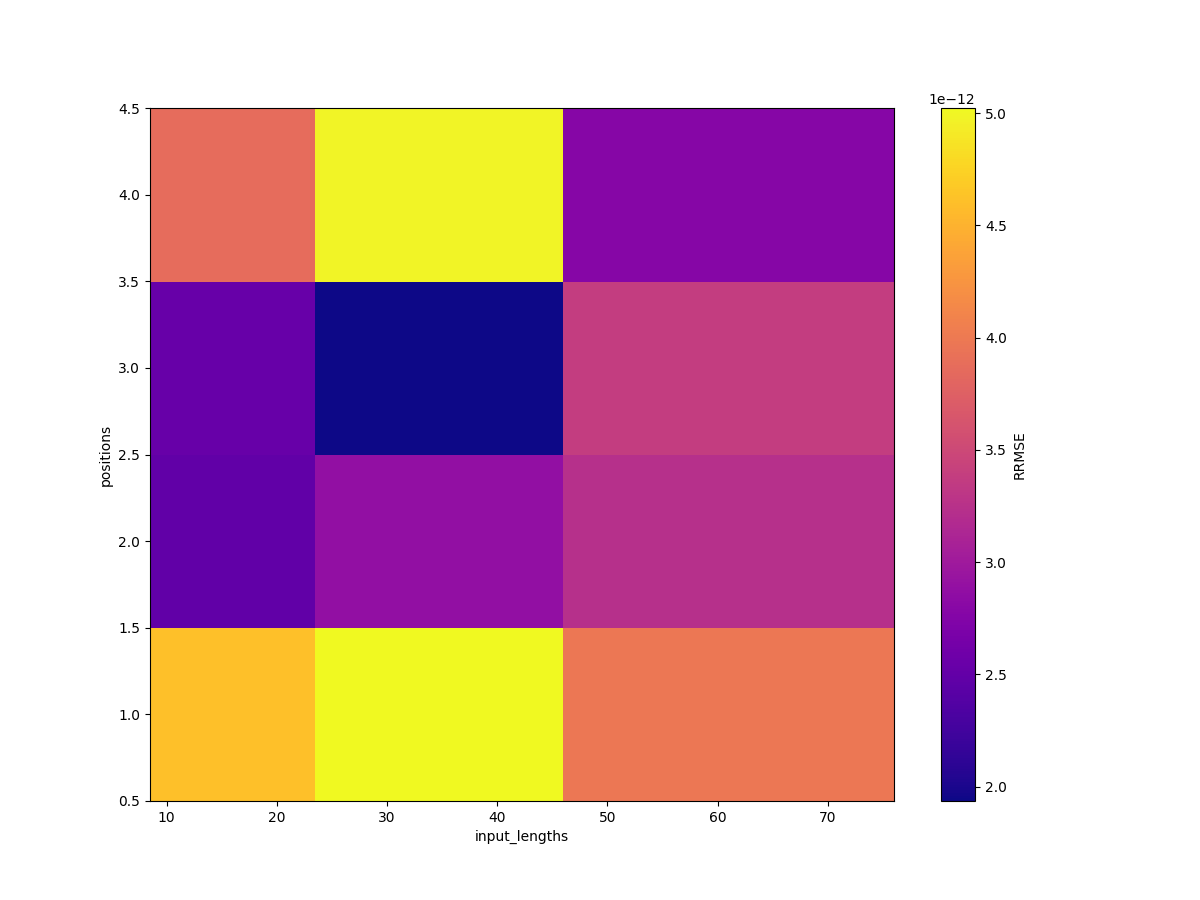

5.0223565609997315e-12


In [63]:
metric=Relative_RMSE_residT
positions=[1,2,3,4]
fig, ax = plt.subplots(figsize=(12,9))
im = ax.pcolor(input_lengths,positions,metric.T,cmap='plasma')
fig.colorbar(im, ax=ax, label='RRMSE')

plt.xlabel('input_lengths')
plt.ylabel('positions')
plt.show()
print(metric.T.max())

#plt.savefig('/home/giacomo/Documents/FIGURES_combined/Noise_matrici/STD_resid.pdf')


SyntaxError: invalid syntax (1466006240.py, line 1)

In [76]:
station='MAHI'
cd='/home/giacomo/Downloads/'    
station='MAHI'
cd='/home/giacomo/Downloads/'    
df=pd.read_csv(cd+station+'.txt',sep=' ',header=None)
data=df.values[:,:3]
t = gen_jjj(data[:,0].astype(int),data[:,1].astype(int),data[:,2].astype(int))

#### Esempio MAHI totale

In [115]:
station='MAHI'
cd='/home/giacomo/Downloads/'    
station='MAHI'
cd='/home/giacomo/Downloads/'    
df=pd.read_csv(cd+station+'.txt',sep=' ',header=None)
df=df[:-10]
data=df.values[:,:3]
t = gen_jjj(data[:,0].astype(int),data[:,1].astype(int),data[:,2].astype(int))
d=df.values[:,4]
r=df.values[:,4]
    

### interpolate
t_old=t
t = np.linspace(t_old[0], t_old[-1], int(t_old[-1]-t_old[0]))
g_interp = np.interp(t, t_old, d-r)
d = np.interp(t, t_old, d)
r=d-g_interp


input_length=61
    
######################## position ########################
position=int(input_length/2)
print('The input_length is: ',input_length,' The position is: ',position)
    
    
scaler_cd='/home/giacomo/Documents/S_NEW_'+str(input_length)  #old/Synthetic_dataset_
modelStep=scaler_cd+'/Step_model_skip'

model=scaler_cd+'/models/'+models_gr+str(position)
tt,dd,rr,predictions,predictions_step,input_length=filter(t,d,r,position,modelStep,model,scaler_cd,max_gap=5)
trend=linregress(tt,dd)
trend_vector=tt*trend.slope+trend.intercept
trend_DL=linregress(tt,(dd-predictions))
trend_vector_DL=tt*trend_DL.slope+trend_DL.intercept

The input_length is:  61  The position is:  30
61
1
178/178 [==============================] - 5s 24ms/step


<IPython.core.display.Javascript object>


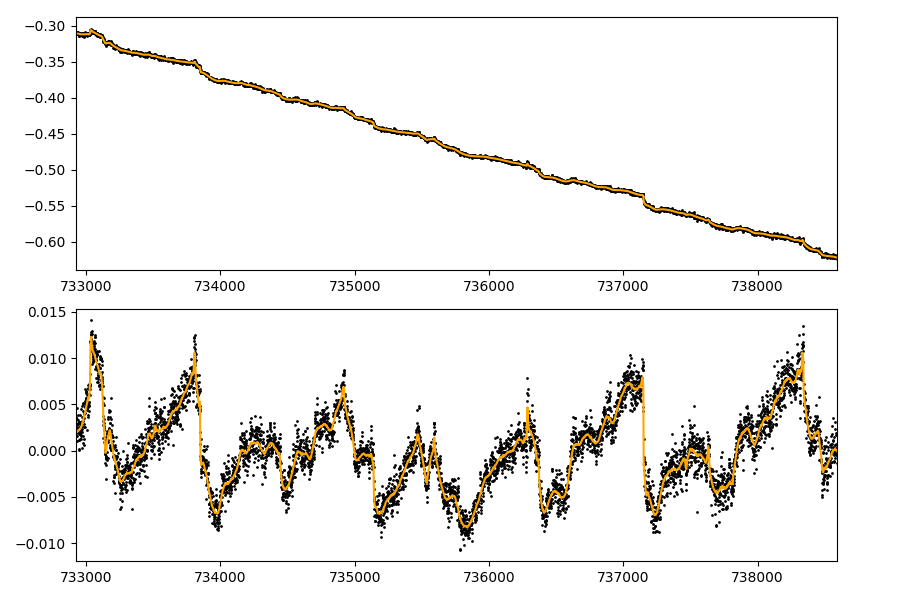

(732923.0, 738589.0)

In [116]:
tt=tt[:-10]
dd=dd[:-10]
predictions=predictions[:-10]
trend_vector_DL=trend_vector_DL[:-10]

fig, axs = plt.subplots(2,1, sharey=False, tight_layout=True,figsize=(9,6))

axs[0].scatter(tt,dd,s=1,color='k')
axs[0].plot(tt,dd-predictions,color='orange')
axs[0].set_xlim(tt[0],tt[-1])

axs[1].scatter(tt,dd-trend_vector_DL,s=1,color='k')
axs[1].plot(tt,(dd-predictions)-trend_vector_DL,color='orange')
axs[1].set_xlim(tt[0],tt[-1])

In [91]:
trend_DL

LinregressResult(slope=-5.4572321531656984e-05, intercept=39.68503581497183, rvalue=-0.9942676022837882, pvalue=0.0, stderr=7.78330018445672e-08, intercept_stderr=0.05726935397318922)